

# Neural style transfer

### About the Project

This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as *neural style transfer* and the technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.). 

Note: This tutorial demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to [cyclegan](cyclegan.ipynb)). This approach is much faster (up to 1000x).

For a simple application of style transfer check out this [tutorial](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) to learn more about how to use the pretrained [Arbitrary Image Stylization model](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) from [TensorFlow Hub](https://tfhub.dev) or how to use a style transfer model with [TensorFlow Lite](https://www.tensorflow.org/lite/models/style_transfer/overview). This project is based on the [Neural style transfer using Tensorflow](https://www.tensorflow.org/tutorials/generative/style_transfer).

## What is Neural Style Transfer?

Neural style transfer is an optimization technique used to take two images—a *content* image and a *style reference* image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

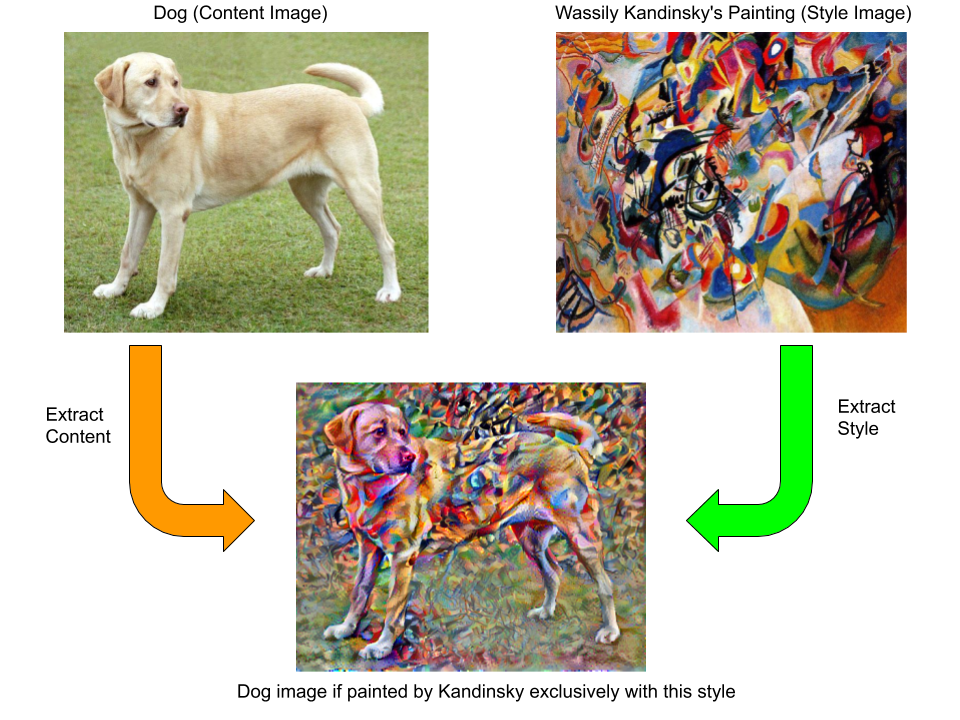

## How is Neural Style Transfer different?
In general, we will have a lot of data and we train the weights by minimizing the loss function.

Unlike other deep learning methods, here we use pre-trained weights which were trained on millions of images and update the pixel values to get the stylized image.

Thus, neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

For example, let’s take an image of this dog and Wassily Kandinsky's Composition 7:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>

[Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), from Wikimedia Commons by [Elf](https://en.wikipedia.org/wiki/User:Elf). License [CC BY-SA 3.0](https://creativecommons.org/licenses/by-sa/3.0/deed.en)

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


Now how would it look like if Kandinsky decided to paint the picture of this Dog exclusively with this style? Something like this?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

##How do we do this?

**What does a CNN do?**

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image.

This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures.

As you step through the network, the final few layers represent higher-level features—object parts like wheels or eyes.

Since the CNNs try to understand the images, they are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances.

Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor.

**What are we going to do?
**
By accessing intermediate layers of the model, we will able to describe the content and style of input images.

Thus, we could use the intermediate layers of the model to get the content and style representations of the image. We will be using the intermediate layers of the VGG19 network architecture, a pre-trained image classification network.

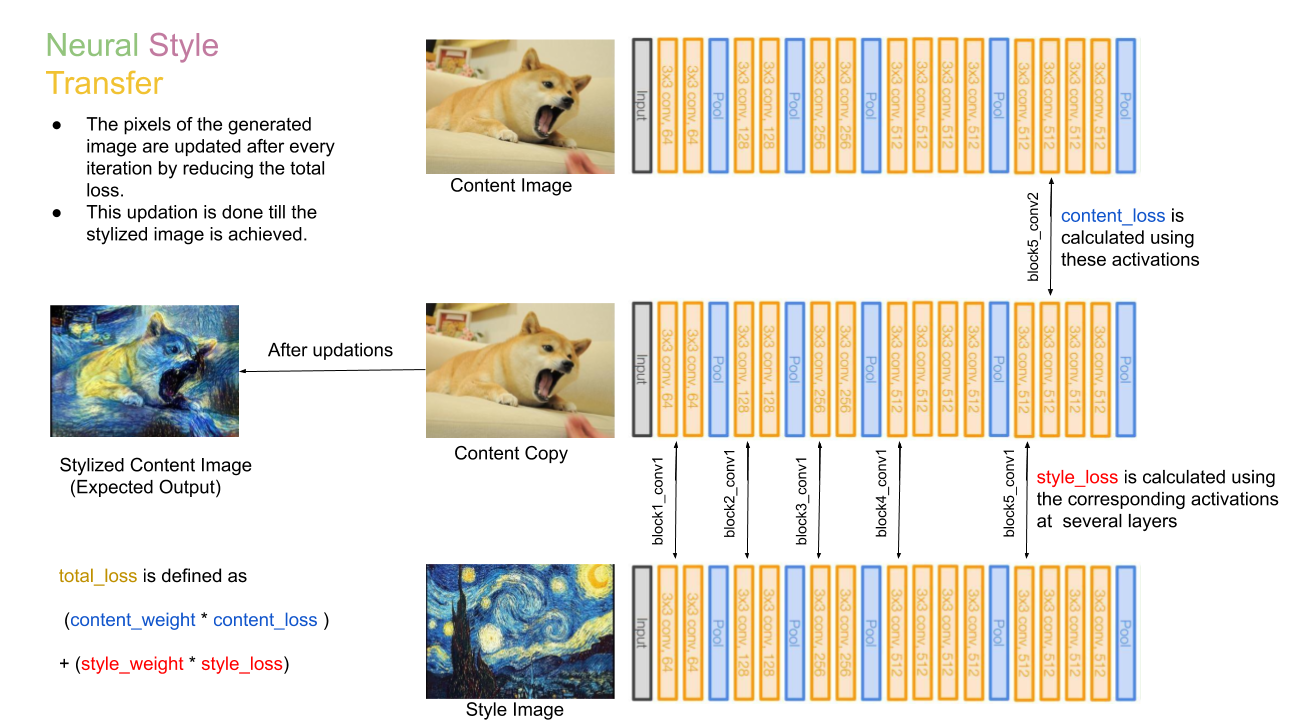



This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.

## Setup


### Import and configure modules

In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
# import functools

In [ ]:
type(tf)

module

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [ ]:
# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [ ]:
# content_path = "/content/lion.jpg"
# content_path = "/content/cxl.png"

# content_path = "/content/monalisa.jpg"
# style_path = "/content/style.jpg"

In [ ]:
content_path = "/content/dog.jpg"
style_path = "/content/moon.jpg"

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

**Note**

- `tf.io.read_file(path_to_img)` reads the entire contents of the input filename. 

 It returns a Tensor of type string which contains bit-representations of the image.

- `tf.image.decode_image(img, channels=3)` detects whether an image is a BMP, GIF, JPEG, or PNG, and performs the appropriate operation to convert the input bytes string into a Tensor of type `uint8`. For `uint8`, minimum value is 0 and maximum value is 255.

  Images that are represented using floating point values are expected to have values in the range [0,1). 
  
  Image data stored in integer data types are expected to have values in the range [0,MAX], where MAX is the largest positive representable number for the data type.

  This op converts between data types, scaling the values appropriately before casting.

- `tf.image.convert_image_dtype(img, tf.float32)` converts the image tensor values to the specified dtype, scaling its values if needed.

- `tf.shape(input_tensor)` returns the shape of a tensor.

- `tf.cast` casts a tensor to a new type.

- `tf.cast(tf.shape(img)[:-1], tf.float32)` converts all the dimensions - except the last dimension - of the `img` to float32 data type.

- `tf.image.resize` resizes image to a specified size.

- `tf.newaxis` is used to increase the dimension of the existing array by one more dimension.

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)

  img = tf.image.decode_image(img, channels=3)

  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)

  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]

  return img

Create a simple function to display an image:

**Note**

- `tf.squeeze` removes dimensions of size 1 from the shape of a tensor.

In [ ]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

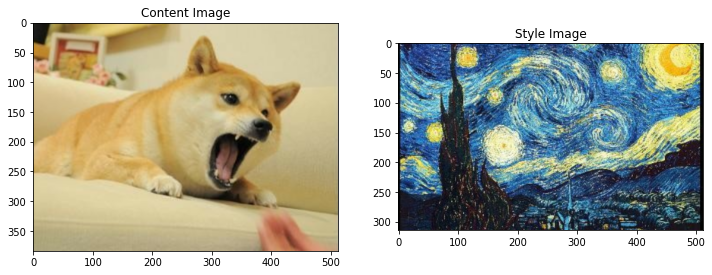

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)


plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [ ]:
print("Style image shape: ",style_image.shape)
print("Content image shape: ", content_image.shape)

Style image shape:  (1, 315, 512, 3)
Content image shape:  (1, 384, 512, 3)


## Define content and style representations

- Use the intermediate layers of the model to get the *content* and *style* representations of the image. 
- Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. 
- As you step through the network, the final few layers represent higher-level features—object parts like *wheels* or *eyes*. In this case, you are using the VGG19 network architecture, a pretrained image classification network. 
- These intermediate layers are necessary to define the representation of content and style from the images.
-For an input image, try to match the corresponding style and content target representations at these intermediate layers.


Load a [VGG19](https://keras.io/applications/#vgg19) and test run it on our image to ensure it's used correctly:

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 4s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('dingo', 0.20264637),
 ('Pembroke', 0.17174132),
 ('basenji', 0.1145933),
 ('Labrador_retriever', 0.04708666),
 ('chow', 0.036214188)]

Now load a `VGG19` without the classification head, and list the layer names

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 0s 0us/step

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image:


In [ ]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

So why do these intermediate outputs within our pretrained image classification network allow us to define style and content representations?

At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

**Note**:

- `tf.keras.applications` are canned architectures with pre-trained weights.

- `tf.keras.applications.VGG19` is VGG19 model for Keras.

- `tf.keras.Model` groups layers into an object with training and inference features.

 It takes a `keras.Input` object or list of `keras.Input` objects, and the other layers as input arguments. 

 - By writing `tf.keras.Model([vgg.input], outputs)`, we are creating a custom Keras CNN model by stacking the vgg19 input layer along with the layers we mentioned in the outputs list.

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

And to create the model:

In [ ]:
style_extractor = vgg_layers(style_layers)
# print(style_image.numpy().min(),style_image.numpy().max())

style_outputs = style_extractor(style_image*255)
# style_outputs = style_extractor(content_image*255)
# print((style_outputs[0])

print("Style layers:", style_layers, "\nContent Layers: ", content_layers)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

Style layers: ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'] 
Content Layers:  ['block5_conv2']
block1_conv1
  shape:  (1, 315, 512, 64)
  min:  0.0
  max:  804.6958
  mean:  29.622654

block2_conv1
  shape:  (1, 157, 256, 128)
  min:  0.0
  max:  3484.251
  mean:  185.36594

block3_conv1
  shape:  (1, 78, 128, 256)
  min:  0.0
  max:  6815.1846
  mean:  172.33904

block4_conv1
  shape:  (1, 39, 64, 512)
  min:  0.0
  max:  16559.871
  mean:  639.32184

block5_conv1
  shape:  (1, 19, 32, 512)
  min:  0.0
  max:  2767.9966
  mean:  50.856003



## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

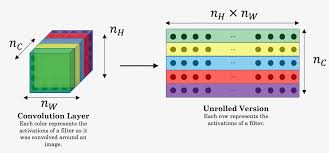


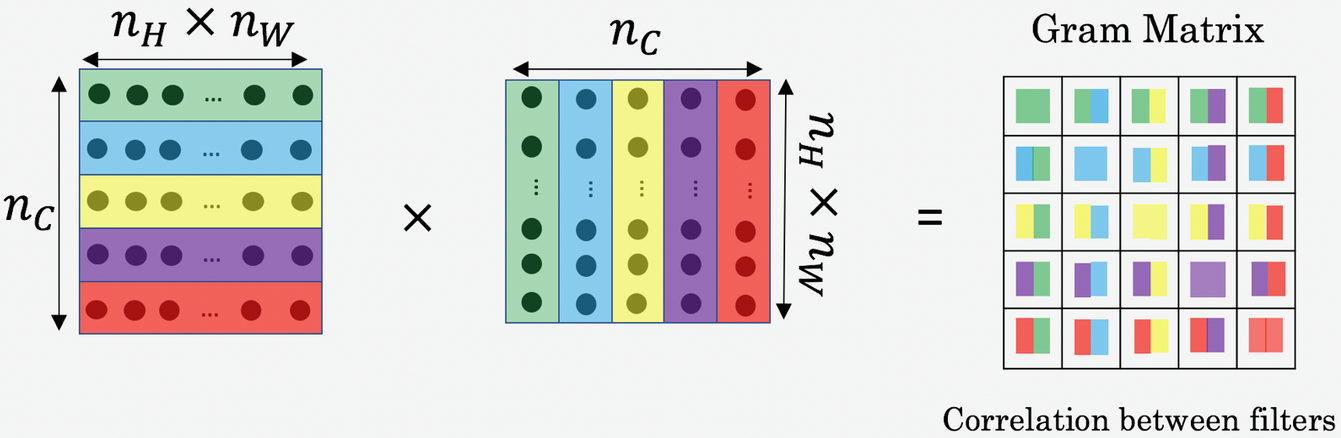

This can be implemented concisely using the `tf.linalg.einsum` function:


Define the function `gram_matrix` and pass the `input_tensor`, which would potentially be the output activations from an intermediate style layer of the input image. We shall implement the following steps in the function:

- Calculate the numerator of the above-mentioned gram matrix formula.

- Divide the thus obtained result with the multiplication of the width and height of the image.

Use the below code to calculate the gram matrix of given input tensor:

In [ ]:
def gram_matrix(input_tensor):
    # print("*-",tf.shape(input_tensor))
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    # print("$ -",result)
    input_shape = tf.shape(input_tensor)
    # print("mul::: ",input_shape[1]*input_shape[2])
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    # print("# -", num_locations)
    return result/(num_locations)

# Gram matrix
# def gram_matrix(tensor):
#   temp = tensor
#   temp = tf.squeeze(temp)
#   fun = tf.reshape(temp, [temp.shape[2], temp.shape[0]*temp.shape[1]])
#   result = tf.matmul(temp, temp, transpose_b=True)
#   gram = tf.expand_dims(result, axis=0)
#   return gram

## Extract style and content


- Build a model that returns the style and content tensors.

- Inside of Keras the Model class is the root class used to define a model architecture. Since Keras utilizes object-oriented programming, we can actually subclass the Model class and then insert our architecture definition.

- Model subclassing is fully-customizable and enables you to implement your own custom forward-pass of the model.

- We are going to define our custom style-content extractor for the given image by subclassing `tf.keras.models.Model`. We do that by:

  - Define `__init()__`:
  
    - Call the `super().__init__()`, the constructor of `tf.keras.models.Model` which is the parent class. 
    - Next, we shall set `self.vgg` to the `vgg_layers` function which we have previously defined. This returns the custom model with the specified style layers and content layers. 
    - Define the layers for content and style extraction in our custom model.
    - It is important to set the `trainable` to `False`, as we want to use the same VGG19 weights trained on ImageNet Database.

  - Define `call` method:

    - `call` method is regarded as the forward pass of the model. We would customize `call` such that we will be returned the gram-matrices representing the style of the image and, the content of the image will be returned. 

    - To do so, we would first scale the input image values to the range [0,255].
    - Then, we shall preprocess the image using `tf.keras.applications.vgg19.preprocess_input`.
    - Next, we shall pass this preprocessed input to our custom model - `self.vgg` - we defined with the specified style and content layers using `vgg_layers` funtion. This returns the `outputs`, which contains the style and content matrices for our input image.
    - Now that we have got the style representation matrices, we shall proceed to calculate the grsm-matrices of each of the style layers. We shall call `gram_matrix` function to do this.
    - Finally, we shall return a dictionary holding the content representations and the layer wise gram-matrices for style representations of the given input image.

**Note:**
- `super().__init__()` calls our parent constructor. From there on, our layers are defined as instance attributes. Attributes in Python use the self  keyword and are typically (but not always) defined in a constructor.

- `tf.keras.applications.vgg19.preprocess_input` returns preprocessed numpy array or a tf.Tensor with type float32. The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

- `call` : Once the layers of our choice are defined, we can then define the network topology/graph inside the call function which is used to perform a forward-pass.



In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    # super(StyleContentModel, self).__init__()
    super().__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    # print("^ - ",inputs)
    inputs = inputs*255.0
    # print(inputs, " - *")
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    # print("!! - ",len(outputs), "- !!")
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

**Note:**

- The `output` returned by the `result` items are of type `tensorflow.python.framework.ops.EagerTensor`. So we shall convert that into numpy array and find the mathematical statistics - like minimum value, mean value, etc - of each output.


In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

# print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

# print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


   block1_conv1
    shape:  (1, 64, 64)
    min:  0.00097527454
    max:  38465.156
    mean:  223.63496

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  41886.008
    mean:  5817.8003

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  177181.83
    mean:  5327.621

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  1249220.6
    mean:  90560.234

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  37045.63
    mean:  915.18506

   block5_conv2
    shape:  (1, 24, 32, 512)
    min:  0.0
    max:  1372.2466
    mean:  11.231071


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values. We shall do this by extracting the style of the style image and content of the content image.

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

**Note:**

- `tf.Variable` represents a tensor whose value can be changed by running ops on it. Specific ops allow you to read and modify the values of this tensor. Higher level libraries like tf.keras use tf.Variable to store model parameters.

*Remember, unlike other deep learning methods, here we use pretrained weights which was trained on millions of images and update the pixel values to get stylized. So we declare a `tf.Variable` to initially hold the content image, whose pixels would be updated with each epoch.*

In [ ]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [ ]:
style_weight=1e-2
content_weight=1e4

# Define the Loss function

- Store the content representation and gram matrices of the style representations of the input image.
- Calculate the mean squared difference between the gram matrices of the respective layers of the input image from the target representations. Add these average squared distances and scale this loss with `style_weight` to obtain the `style_loss`.
- Calculate the squared difference between the content representations of the input image from the target representations.  Add these average squared distances and scale this loss with `content_weight` to obtain the `content_loss`.
- Add the `style_loss` and `content_loss` to obtain the total loss `loss`.

**Note:**

- `tf.reduce_mean` computes the mean of elements across dimensions of a tensor.

- `tf.add_n` adds all input tensors element-wise.

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()]
                        )
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Now it's the time to define the training step. We shall use `tf.GradientTape` to update the image.

Let us define `train_step(image)` function which performs the calculation of gradient and updation of image pixel values for each train step epoch. 

In defining the `train_step` function, the following steps are implemented:

- Calculate the `outputs` which are the style and content representations of the input image, using the `extractor` which is the object of `StyleContentModel`. 
 Then, call the function `style_content_loss` function to get the weighted-loss of the input image.
  Record all these operations using `tf.GradientTape()`.

- Based on the thus obtained loss, calculate the gradients, using `tape.gradient(loss, image)`.

- Then, apply these gradients using `opt.apply_gradients.

- Finally, update the image as per the gradients and clip the pixel values to be in 0-1 range.

**Note:**

- `@tf.function` converts a Python function to its graph representation for Faster execution, especially if the function consists of many small ops.
 The pattern to follow is to define the training step function, that's the most computationally intensive function, and decorate it with @tf.function. 


- `tf.GradientTape()`: `tf.GradientTape()` records the list of the operations, so that these could be used for automatic differentiation during optimization. It is very highly recommended to go through [the official docs][1] in order to gain a bigger picture of this. 

- `optimizer.apply_gradients` applies the gradients.


  [1]: https://www.tensorflow.org/guide/autodiff

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

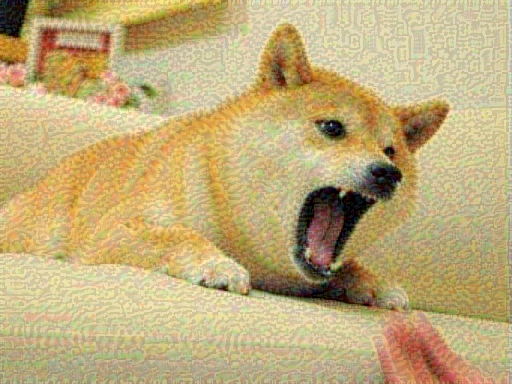

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

- Since it's working, perform a longer optimization.

- We shall implement the optimization as follows:

 - Let us go perform10 epochs, each having 10 steps.

 - In each step, we will be calling the `train_step` function which implements the actual optimization of the image pixels by calling various fore-defined functions for each iteration. 

 - For each epoch, let us display the image with the updated pixels.

 - Let us also calculate the amount of time taken to perform this optimization. Let us use the `time` module. 

**Note:**

- `time.time()` method returns the time as a floating-point number expressed in seconds since the epoch, in UTC.

 We shall store the starting time in using `time.time()` in the beginning of the optimization code, and `end=time.time()`. Then, `end-start` gives the elapsed seconds taken to perform the optimization.

- We imported `IPython.display` as `display` in the beginning of the exercise. Now,

 - `display.clear_output()` clears the output of the current cell receiving the output.
 It has a boolean parameter `wait`. If it is turned `True`, it means to wait to clear the output until the new output is available to replace it.

 - `display.display()` displays a Python object in all frontends.

- Due to the time and resource constraints, we have selected the specified number of epochs and steps. You could try out increasing the total number of iterations like 1000, and observe the results for yourself if you get to use GPUs.

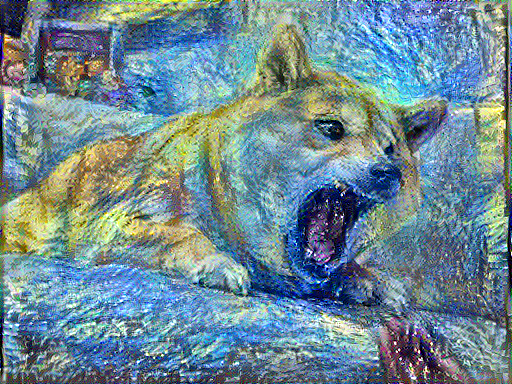

Train step: 1000
Total time: 63.8


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))

Finally, save the result:

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

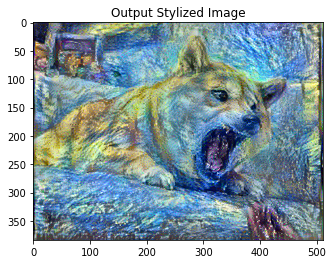

In [ ]:
stylized_image = load_img("/content/stylized-image.png")
plt.figure(figsize=(6,4))
imshow(stylized_image, 'Output Stylized Image')